This notebook compares quartet inference on simulated data by a softmax regression machine learning model to that by SVDquartets.

## Imports

In [30]:
import numpy as np
import h5py
import re
import random
from itertools import compress
import itertools
import math
from operator import itemgetter
import sys
from Bio import Phylo
import tensorflow as tf
import numpy as np
from pathlib2 import Path
import gc
import contextlib
import io
import itertools
import os
import ipyrad as ip
import subprocess
from ipyrad.assemble.util import IPyradWarningExit, progressbar, Params
from toytree import ete3mini as ete3
import re

## Function
Reads in sequence data generated on a phylogeny, along with the phylogeny. 

Returns a sequence matrix split on t1, t2 | t3, t4, as well as a three-element array of what the real split is in the tree. 

To define the real split on the tree:

[1, 0, 0] = t1, t2 | t3, t4

[0, 1, 0] = t1, t3 | t2, t4

[0, 0, 1] = t1, t4 | t2, t3

In [2]:
def compare_quint_pred_actual(sequencedata, phylogeny,tipnames):
    # read in data

    fname = sequencedata
    with open(fname) as f:
        sequences = f.readlines()

    # remove whitespace characters like `\n` at the end of each line

    sequences = [x.strip() for x in sequences] 
    sequences.pop(0)

    # get sequences  and identify quintet taxa
    names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
    iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]
    
    # so we're only testing one possible quartet per tree... Easy to expand this to test every quintet per tree
    interestednames = tipnames # this should be a list of four tip names... e.g. ["t1","t2","t3","t4]
    taxa_ids = list(itertools.chain.from_iterable([list(compress(range(10),i)) for i in [[q == i for i in names] for q in interestednames]]))
    
    #taxa_ids = [3,2,8,9]
    #fourtaxa = [names[i] for i in taxa_ids]

    tempobj = [iso_sequences[i] for i in taxa_ids]

    # eliminate non-snps

    ind_samples = []
    for i in range(len(tempobj[0])):
        currentbase = ([tempobj[q][i] for q in range(len(tempobj))])
        if (len(set(currentbase)) > 1):
            ind_samples.append(currentbase)
    ind_samples_reset = ind_samples

    # separate sequences by fifth taxon

    ind_samples = np.array(ind_samples_reset)
    ind_samples = np.where(ind_samples=='A',0,ind_samples)
    ind_samples = np.where(ind_samples=='C',1,ind_samples)
    ind_samples = np.where(ind_samples=='G',2,ind_samples)
    ind_samples = np.where(ind_samples=='T',3,ind_samples)
    ind_samples = ind_samples.astype(int)

    # get the matrices
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)
    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = ind_samples
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0],arr0123[i][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2],arr0123[i][3]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
    #allmats.append(fullmat0123)

    # predict the true quintet

    # compare with actual quintet

    tree = Phylo.read(phylogeny, 'newick')

    tipnames = [names[i] for i in taxa_ids]
    indexing = np.array([[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]])

    alldists = [tree.distance(tipnames[0],tipnames[1]),
                tree.distance(tipnames[0],tipnames[2]),
                tree.distance(tipnames[0],tipnames[3]),
                tree.distance(tipnames[1],tipnames[2]),
                tree.distance(tipnames[1],tipnames[3]),
                tree.distance(tipnames[2],tipnames[3])]

    min_tree_pairs1, min_pair_val1 = min(enumerate(alldists), key=itemgetter(1))
    
    paired_taxa =  [tipnames[i] for i in list(indexing[min_tree_pairs1])] + [tipnames[i] for i in list(set([0,1,2,3]) ^ set(list(indexing[min_tree_pairs1])))]
    quartet_numbers = list(itertools.chain.from_iterable([list(compress(range(10),i)) for i in [[q == i for i in names] for q in paired_taxa]]))
    
    # is this a 0123, 0213, or 0312?
    correct_config = np.array([(set([taxa_ids[i] for i in [0,1,2,3]][2:4]) == set(quartet_numbers[2:4]) or 
                                    set([taxa_ids[i] for i in [0,1,2,3]][2:4]) == set(quartet_numbers[0:2])),
                                (set([taxa_ids[i] for i in [0,2,1,3]][2:4]) == set(quartet_numbers[2:4]) or 
                                    set([taxa_ids[i] for i in [0,2,1,3]][2:4]) == set(quartet_numbers[0:2])),
                                (set([taxa_ids[i] for i in [0,3,1,2]][2:4]) == set(quartet_numbers[2:4]) or 
                                    set([taxa_ids[i] for i in [0,3,1,2]][2:4]) == set(quartet_numbers[0:2]))]).astype(int)
    
    return(taxa_ids,quartet_numbers,paired_taxa,correct_config,fullmat0123)
    
    
    
    

Now apply the function to all of our tree/sequence combinations, saving the sequence matrices as `images` and the true splits as `labels`:

In [3]:
images = []
labels = []

for i in range(1,2001):
    test = compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=["t1","t2","t3","t4"])
    images.append(test[4].flatten()/max(test[4].flatten()))
    labels.append(test[3])

Now run a very simple (as in, from the tensorflow tutorial) softmax regression model.

In [65]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 256])
W = tf.Variable(tf.zeros([256, 3]))
b = tf.Variable(tf.zeros([3]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 3])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.6).minimize(cross_entropy)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)


    #sess = tf.InteractiveSession()
    #tf.global_variables_initializer().run()

    for _ in range(1000):
      batch = np.random.choice(1000, 50)
      batch_xs, batch_ys = np.array([images[i] for i in batch]),np.array([labels[i] for i in batch])
      sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: images[1001:2000], y_: labels[1001:2000]}))
    save_path = saver.save(sess, "download_simseqs/saved_mo.ckpt")

0.986987


In [136]:
predictions = sess.run(y, feed_dict={x: [images[7]]})
int(tf.argmax(predictions,1).eval())

0

This shows 98.6% successful prediction of quartet arrangements by our simple machine learning model.

This high rate is easy to accomplish because the seq-gen settings are really basic, and we have lots of loci to work with. With real data, we'd want more sophisticated models and would still probably end up with lower rates of success. Model training relies on simulated sequence data, so making the jump to empirical data might be hard. We'd need a way to test robustness of the model to variation in data. 

Many of the branch lengths on the simulated trees used here ended up being very short, so the high rate of success is still a good sign. 

This is also promising because it could be easily extended beyond four taxa.

## SVDquartets inference on same data

The loop below makes a bunch of quartet decisions on the same set of sequences.

In [316]:
chosenindexlist = []
for w in range(1001,2001):
    sequencedata = "tree_seqs/test" + str(w) + ".dat"
    # read in data

    fname = sequencedata
    with open(fname) as f:
        sequences = f.readlines()

    # remove whitespace characters like `\n` at the end of each line

    sequences = [x.strip() for x in sequences] 
    sequences.pop(0)

    # get sequences  and identify quintet taxa
    names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
    iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]
    
    # so we're only testing one possible quartet per tree... Easy to expand this to test every quintet per tree
    interestednames = ["t1","t2","t3","t4"]
    taxa_ids = list(itertools.chain.from_iterable([list(compress(range(10),i)) for i in [[q == i for i in names] for q in interestednames]]))
    
    #taxa_ids = [3,2,8,9]
    #fourtaxa = [names[i] for i in taxa_ids]

    tempobj = [iso_sequences[i] for i in taxa_ids]

    # eliminate non-snps

    ind_samples = []
    for i in range(len(tempobj[0])):
        currentbase = ([tempobj[q][i] for q in range(len(tempobj))])
        if (len(set(currentbase)) > 1):
            ind_samples.append(currentbase)
    ind_samples_reset = ind_samples

    # separate sequences by fifth taxon

    ind_samples = np.array(ind_samples_reset)
    ind_samples = np.where(ind_samples=='A',0,ind_samples)
    ind_samples = np.where(ind_samples=='C',1,ind_samples)
    ind_samples = np.where(ind_samples=='G',2,ind_samples)
    ind_samples = np.where(ind_samples=='T',3,ind_samples)
    ind_samples = ind_samples.astype(int)
    
    possible_configs = [[0,1,2,3],[0,2,1,3],[0,3,1,2]]
    # get the matrices
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)
    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = ind_samples
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0],arr0123[i][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2],arr0123[i][3]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
 

    fullmat0213 = np.zeros(shape=(16,16))
    arr0213 = ind_samples[:,possible_configs[1]]
    for i in range(len(arr0213)):
        # get row number 
        rownum = int(indexmat[arr0213[i][0:2][0],arr0213[i][0:2][1]])
        # get col number
        colnum = int(indexmat[arr0213[i][2:4][0],arr0213[i][2:4][1]])
        fullmat0213[rownum,colnum] = fullmat0213[rownum,colnum] + 1

    fullmat0312 = np.zeros(shape=(16,16))
    arr0312 = ind_samples[:,possible_configs[2]]
    for i in range(len(arr0312)):
        # get row number 
        rownum = int(indexmat[arr0312[i][0:2][0],arr0312[i][0:2][1]])
        # get col number
        colnum = int(indexmat[arr0312[i][2:4][0],arr0312[i][2:4][1]])
        fullmat0312[rownum,colnum] = fullmat0312[rownum,colnum] + 1
    #score the matrices here
    scores = [math.sqrt(np.sum(np.square(np.linalg.svd(fullmat0123)[1][10:15]))),math.sqrt(np.sum(np.square(np.linalg.svd(fullmat0213)[1][10:15]))),math.sqrt(np.sum(np.square(np.linalg.svd(fullmat0312)[1][10:15])))]
    #choose best scoring matrix
    min_index, min_value = min(enumerate(scores), key=itemgetter(1))
    chosenindex = np.array([0,0,0])
    chosenindex[min_index] = 1
    chosenindexlist.append(chosenindex)

Now we tally up the correctly inferred quartets...

In [323]:
truequarts = [labels[i] for i in range(1000,2000)]
tally = 0
for w in range(len(truequarts)):
    if (sum(truequarts[w] == chosenindexlist[w]) == 3):
        tally = tally + 1

And, finally, get the percent correct under SVDquartets:

In [326]:
tally / 1000.

0.935

So 93.5 percent of quartets inferred by SVDquartets are correct, although I won't rule out the possibility that I'm doing the scoring incorrectly.

The softmax model had the benefit of being tailored specifically to the simulated data and making predictions on data generated under the same model. SVDquartets quartet selection performs pretty well regardless, which we can't yet say for softmax or a similar machine learning model.

## Next steps:

*  Mix together models of sequence evolution for training set, perform inference on mixed simulations.
*  Compare success of different types of trainings on empirical inference (even showing consistency would go a long way).
*  Improve machine learning model past single layer.

In [104]:
alltips = ["t1","t2","t3","t4","t5","t6","t7","t8","t9","t10"]
alltipcombns=list(itertools.combinations(alltips, 4))

In [105]:
i=100
all_mats = [compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=q)[4] for q in alltipcombns]



In [117]:
chosenquarts = []
for i in all_mats:
    predictions = sess.run(y, feed_dict={x: [i.flatten()/max(i.flatten())]})
    chosenquarts.append(int(tf.argmax(predictions,1).eval()))


In [220]:
correctquarts = [[alltipcombns[q][i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][chosenquarts[q]]] for q in range(len(chosenquarts))]
names = ["t1","t2","t3","t4","t5","t6","t7","t8","t9","t10"]
ids = range(len(names))


In [215]:
correctquarts= np.array(correctquarts)

In [233]:
for q in range(len(names)):
    correctquarts = [[re.sub(r'\b'+ names[q] +r'\b', str(ids[q]), correctquarts[w][i]) for i in range(4)] for w in range(len(correctquarts))]


In [44]:
def dump_qmc(quartets,tempfiledir):
    """
    Writes the inferred quartet sets from the database to a text 
    file to be used as input for QMC. Quartets that had no information
    available (i.e., no SNPs) were written to the database as 0,0,0,0
    and are excluded here from the output.
    """

    ## open the h5 database
    #with h5py.File(self.database.output, 'r') as io5:

        ## create an output file for writing
    tempfile = os.path.join(tempfiledir,"quartets.txt")
    with open(tempfile, 'w') as qdump:

        ## pull from db
        #for idx in xrange(0, self.params.nquartets, self._chunksize):
            #quarts = quartets

            ## shuffle and format for qmc
            #np.random.shuffle(quarts)
            chunk = ["{},{}|{},{}".format(*i) for i in quartets]
            qdump.write("\n".join(chunk)+"\n")


def _run_qmc(tempfiledir, tempfilename,treename,tipnames):
    """
    Runs quartet max-cut QMC on the quartets qdump file.
    """

    ## build command
    thetmptree = os.path.join(tempfiledir, "tmptre.phy")
    cmd = [ip.bins.qmc, "qrtt="+tempfilename, "otre="+thetmptree]

    ## run it
    proc = subprocess.Popen(cmd, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    res = proc.communicate()
    #if proc.returncode:
    #    print(proc.returncode)
    #    raise IPyradWarningExit(res[1])

    ## parse tmp file written by qmc into a tree and rename it
    with open(thetmptree, 'r') as intree:
        tre = ete3.Tree(intree.read().strip())
        names = tre.get_leaves()
        for name in names:
            name.name = tipnames[(int(name.name)-1)]
        tmptre = tre.write(format=9)

    ## save the tree to file
    #if boot:
    #    self.trees.boots = os.path.join(self.dirs, self.name+".boots")
    #    with open(self.trees.boots, 'a') as outboot:
    #        outboot.write(tmptre+"\n")
    #else:
    treepath  = os.path.join(tempfiledir, treename+".tree")
    with open(treepath, 'w') as outtree:
        outtree.write(tmptre)

    ## save the file
    #treepath._save()

In [236]:
dump_qmc(correctquarts,"")


In [243]:
_run_qmc(tempfiledir="",tempfilename = "quartets.txt",treename="mytree",tipnames=names)

## Mammals dataset

### Name your current quartet

In [52]:
fourtaxa = [0,1,2,3]

### Get all independent snps for quartet

In [99]:
genesnps = np.array([]).reshape(0,4)
for gene in range(1,447):
    fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/"+ str(gene) +".fasta_relabeled.phy"
    if Path(fname).is_file():
        raw = open(fname, 'r')
        snps = file.read(raw) 
        snps = snps.split('\n')
        # remove whitespace characters like `\n` at the end of each line
        snps = [x.strip() for x in snps] 
        snps.pop(0)
        [snps.pop(i) for i in range(len(snps)) if not len(snps[i])]

        snps = [snps[i].split(" ") for i in range(len(snps))]
        snps = [filter(None, snps[i]) for i in range(len(snps))]

        ids = [snps[i][0] for i in range(len(snps))]
        sequences = [snps[i][1] for i in range(len(snps))]
        fourfullseqs = [sequences[i] for i in fourtaxa]
        snpseqs = np.array([]).reshape(0,4)
        for q in range(len(fourfullseqs[0])):
            current4bases=[fourfullseqs[i][q] for i in range(4)]
            if ((len(set(current4bases).union(set(['A','G','C','T']))) == 4) and (len(set(current4bases)) > 1)):
                snpseqs = np.vstack([snpseqs, current4bases])
        if len(snpseqs):
            genesnps = np.vstack([genesnps,snpseqs[np.random.choice(len(snpseqs))]])

### Make the quartet matrix

In [104]:
snps = np.array(genesnps)
possible_configs = [0,1,2,3]
snps = np.where(snps=='A',0,snps)
snps = np.where(snps=='C',1,snps)
snps = np.where(snps=='G',2,snps)
snps = np.where(snps=='T',3,snps)
snps = snps.astype(int)
finalsnps = snps

# make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
indexmat = np.array(range(16))
indexmat.shape=(4,4)

        # make 16x16 matrix of zeroes
        # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
        # not good use of space
fullmat0123 = np.zeros(shape=(16,16))
arr0123 = finalsnps[:,possible_configs]
for i in range(len(arr0123)):
            # get row number 
    rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
            # get col number
    colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
    fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1

### Predict the correct quartet configuration

In [116]:
prediction = sess.run(y, feed_dict={x: [fullmat0123.flatten()/max(fullmat0123.flatten())]})

In [120]:
[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(tf.argmax(prediction,1).eval())]]

[0, 2, 1, 3]

### Now make a prediction for all quartets!

In [235]:
alltipcombns=list(itertools.combinations(range(37), 4))

In [236]:
len(alltipcombns) # this is a lot. But we're tough.

66045

In [59]:
alltipcombns = alltipcombns.astype(int)

In [237]:
random.shuffle(alltipcombns) # maybe just in case we don't get all the way through.

In [83]:
allpredictedquarts = np.array([]).reshape(0,4)
for currentcombn in [alltipcombns[allcom] for allcom in range(18100,66045)]:
    fourtaxa = np.array(currentcombn).astype(int)
    genesnps = np.array([]).reshape(0,4)
    for gene in range(1,447):
        fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/"+ str(gene) +".fasta_relabeled.phy"
        if Path(fname).is_file():
            raw = open(fname, 'r')
            snps = file.read(raw) 
            snps = snps.split('\n')
            # remove whitespace characters like `\n` at the end of each line
            snps = [xs.strip() for xs in snps] 
            snps.pop(0)
            [snps.pop(i) for i in range(len(snps)) if not len(snps[i])]

            snps = [snps[i].split(" ") for i in range(len(snps))]
            snps = [filter(None, snps[i]) for i in range(len(snps))]

            ids = [snps[i][0] for i in range(len(snps))]
            sequences = [snps[i][1] for i in range(len(snps))]
            fourfullseqs = [sequences[i] for i in fourtaxa]
            snpseqs = np.array([]).reshape(0,4)
            for q in range(len(fourfullseqs[0])):
                current4bases=[fourfullseqs[i][q] for i in range(4)]
                if ((len(set(current4bases).union(set(['A','G','C','T']))) == 4) and (len(set(current4bases)) > 1)):
                    snpseqs = np.vstack([snpseqs, current4bases])
            if len(snpseqs):
                genesnps = np.vstack([genesnps,snpseqs[np.random.choice(len(snpseqs))]])

    snps = np.array(genesnps)
    possible_configs = [0,1,2,3]
    snps = np.where(snps=='A',0,snps)
    snps = np.where(snps=='C',1,snps)
    snps = np.where(snps=='G',2,snps)
    snps = np.where(snps=='T',3,snps)
    snps = snps.astype(int)
    finalsnps = snps

    # make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)

            # make 16x16 matrix of zeroes
            # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
            # not good use of space
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = finalsnps[:,possible_configs]
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
    prediction = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
    allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(tf.argmax(prediction,1).eval())]]])
    print(len(allpredictedquarts))
    

TypeError: Cannot interpret feed_dict key as Tensor: The name 'Orn\t37' looks like an (invalid) Operation name, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

In [73]:
len(allpredictedquarts)

3870

In [12]:
alltipcombns[4830]

array([ 14.,  29.,  33.,  34.])

In [322]:
range(4830,66045)

66044

In [18]:
len(allpredictedquarts)

2200

In [77]:
test = np.loadtxt("download_simseqs/mammal_quarts.gz")

In [78]:
len(test)

18100

In [55]:
alltipcombns = np.loadtxt("download_simseqs/combn_order.gz")

In [76]:
#np.savetxt("download_simseqs/mammal_quarts.gz",np.vstack([test,allpredictedquarts]))
#np.savetxt("download_simseqs/combn_order.gz",alltipcombns)

In [79]:
with open("download_simseqs/song-mammalian-bio_completely_processed/taxa_dict.txt") as f:
    test = f.readlines()
test = [x.strip() for x in test]
nameskey = [test[i].split("\t") for i in range(len(test))]
[i[0] for i in nameskey] # this gives just the names

['Mac',
 'New',
 'Sor',
 'Gor',
 'Oto',
 'Spe',
 'Ory',
 'Tup',
 'Dip',
 'Tur',
 'Mic',
 'Eri',
 'Och',
 'Lox',
 'Fel',
 'Tar',
 'Pro',
 'Ech',
 'Das',
 'Myo',
 'Mus',
 'Rat',
 'Cav',
 'Cho',
 'Bos',
 'Cal',
 'Pon',
 'Hom',
 'Pan',
 'Sus',
 'Vic',
 'Can',
 'Pte',
 'Equ',
 'Gal',
 'Mon',
 'Orn']

In [80]:
allpredictedquarts = np.loadtxt("download_simseqs/mammal_quarts.gz")
allpredictedquarts = allpredictedquarts.astype(int)

In [81]:
dump_qmc(quartets = allpredictedquarts,tempfiledir= "download_simseqs/")

In [82]:
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="tree4830.phy",
         tipnames=[i[0] for i in nameskey])

## Save block of snps and a map file

In [9]:
fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/1.fasta_relabeled.phy"

In [20]:
begins = [0]
ends = []
totalseqs = np.empty(shape = (0,37))
for filenum in range(1,448):
    fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/"+str(filenum)+".fasta_relabeled.phy"
    if Path(fname).is_file():
        raw = open(fname, 'r')
        snps = file.read(raw) 
        snps = snps.split('\n')
        # remove whitespace characters like `\n` at the end of each line
        snps = [xs.strip() for xs in snps] 
        snps.pop(0)
        [snps.pop(i) for i in range(len(snps)) if not len(snps[i])]

        snps = [snps[i].split(" ") for i in range(len(snps))]
        snps = [filter(None, snps[i]) for i in range(len(snps))]
        
        # make column and get rid of non-snps (if these exist)
        snpcols = np.array([[snps[i][1][q] for i in range(len(snps))] for q in range(len(snps[0][1]))])
        accepted = [snpcols[q] for q in range(len(snpcols)) if len(set(snpcols[q]).intersection(set(['A','G','C','T']))) > 1]
        
        # append the arrays 
        totalseqs = np.vstack([totalseqs,np.array(accepted)])
        

        # save map data
        ends.append(begins[-1] + len(accepted))
        begins.append(ends[-1])
        print(filenum)
# get rid of this extra map index
begins.pop(len(begins)-1)

1
2
3
4
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
48
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
76
77
78
79
80
81
82
83
84
85
86
87
88
89
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
198
201
202
203
204
205
206
207
208
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
258
259
260
261
262
263
264
265
266
267
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293

721605

In [22]:
np.savetxt("download_simseqs/concat_mammal_genes.gz",totalseqs,fmt="%s")
np.savetxt("download_simseqs/concat_mammal_map.gz",np.array([begins,ends]))

## Now load these files and infer quartets

In [8]:
totalseqs = np.genfromtxt("download_simseqs/concat_mammal_genes.gz",dtype='str')
snpmap = np.loadtxt("download_simseqs/concat_mammal_map.gz").astype(int)

In [9]:
alltipcombns=np.array(list(itertools.combinations(range(37), 4)))
alltipcombns = alltipcombns.astype(int)

In [10]:
genes_alltaxa = [totalseqs[snpmap[0][i]:snpmap[1][i]] for i in range(len(snpmap[0]))]

The object `combocounter` keeps track of which combination we're on overall. The object `savecounter` keeps track of where we are in-between saves to the output .txt file and is reset every time we save data to that file.

This function starts to run slowly because for some reason memory isn't freed up as it loops. Added a `gc.collect()` function to try to fix this, without success. Either multiprocessing module or numba might fix this.

In [11]:
combocounter = 0
targetlen = len(alltipcombns)

# the first time you run this, run the next two lines to make a new file:

#orig_file = np.empty(shape = (0,4))
#np.savetxt("download_simseqs/mammal_quarts.txt",orig_file)

while combocounter < (targetlen -1):
    allpredictedquarts = np.empty(shape = (0,4))
    gc.collect()
    savecounter = 0 # this will be reset
    while (savecounter < 200) and (combocounter < (targetlen)):
        # set your current combination of four taxa
        fourtaxa= alltipcombns[combocounter]

        # get one snp at each locus -- might eventually be better to build a distribution at each locus, or 
        # at least compare quality of inference done both ways

        # before, I'd been getting all informative, complete SNPs at each locus and then randomly selecting. 
        # Much more efficient this way, shuffling each locus randomly and then selecting first informative SNP

        reducedgene = np.empty(shape = (0,4))
        for geneidx in range(len(genes_alltaxa)):
            currentgene = genes_alltaxa[geneidx]
            orderedsamples = range(len(currentgene))
            np.random.shuffle(orderedsamples)
            trigger = 0
            q = 0
            while (trigger == 0) and (q < (len(currentgene)-1)):
                currentgene = [genes_alltaxa[geneidx][orderedsamples[q]][taxon] for taxon in fourtaxa]
                q += 1
                if ((len(set(currentgene).union(set(['A','G','C','T']))) == 4) and (len(set(currentgene)) > 1)):
                    reducedgene = np.vstack([reducedgene,currentgene])
                    trigger = 1

        snps = np.array(reducedgene)
        possible_configs = [0,1,2,3]
        snps = np.where(snps=='A',0,snps)
        snps = np.where(snps=='C',1,snps)
        snps = np.where(snps=='G',2,snps)
        snps = np.where(snps=='T',3,snps)
        snps = snps.astype(int)
        finalsnps = snps

        # make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
        indexmat = np.array(range(16))
        indexmat.shape=(4,4)

                # make 16x16 matrix of zeroes
                # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
                # not good use of space
        fullmat0123 = np.zeros(shape=(16,16))
        arr0123 = finalsnps[:,possible_configs]
        for i in range(len(arr0123)):
                    # get row number 
            rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
                    # get col number
            colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
            fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
        prediction = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
        allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(tf.argmax(prediction,1).eval())]]])
        #print(str(savecounter) +" " + str(combocounter))
        savecounter += 1
        combocounter += 1
    f_handle = file("download_simseqs/mammal_quarts.txt","a")
    np.savetxt(f_handle,allpredictedquarts.astype(int))
    f_handle.close()
    


### Once this is done, make your tree!

In [17]:
allpredictedquarts = np.loadtxt("download_simseqs/mammal_quarts.txt")

In [18]:
with open("download_simseqs/song-mammalian-bio_completely_processed/taxa_dict.txt") as f:
    test = f.readlines()
test = [x.strip() for x in test]
nameskey = [test[i].split("\t") for i in range(len(test))]
[i[0] for i in nameskey] # this gives just the names

['Mac',
 'New',
 'Sor',
 'Gor',
 'Oto',
 'Spe',
 'Ory',
 'Tup',
 'Dip',
 'Tur',
 'Mic',
 'Eri',
 'Och',
 'Lox',
 'Fel',
 'Tar',
 'Pro',
 'Ech',
 'Das',
 'Myo',
 'Mus',
 'Rat',
 'Cav',
 'Cho',
 'Bos',
 'Cal',
 'Pon',
 'Hom',
 'Pan',
 'Sus',
 'Vic',
 'Can',
 'Pte',
 'Equ',
 'Gal',
 'Mon',
 'Orn']

In [45]:
dump_qmc(quartets = (allpredictedquarts.astype(int)+1),tempfiledir= "download_simseqs/")
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="treeFULL.phy",
         tipnames=[i[0] for i in nameskey])

### This tree is not very accurrate, suggesting either our network isn't designed well or hasn't been trained on appropriate data. To figure this out, we should take the same model and try it out on simulated data that matches the mammal gene data. If it performs poorly (as I expect), we should train on matching data and see if results improve. If so, retry this on the mammal gene data. If it performs well, then perhaps the problem is less with quartet inference and has more to do with tree reconstruction (perhaps QMC isn't meant to be used on such large trees). Could test quartet-by-quartet to see.

### First: write out a function that we can improve on.

In [31]:
def dump_qmc(quartets,tempfiledir):
    """
    Writes the inferred quartet sets from the database to a text 
    file to be used as input for QMC. Quartets that had no information
    available (i.e., no SNPs) were written to the database as 0,0,0,0
    and are excluded here from the output.
    """

    ## open the h5 database
    #with h5py.File(self.database.output, 'r') as io5:

        ## create an output file for writing
    tempfile = os.path.join(tempfiledir,"quartets.txt")
    with open(tempfile, 'w') as qdump:

        ## pull from db
        #for idx in xrange(0, self.params.nquartets, self._chunksize):
            #quarts = quartets

            ## shuffle and format for qmc
            #np.random.shuffle(quarts)
            chunk = ["{},{}|{},{}".format(*i) for i in quartets]
            qdump.write("\n".join(chunk)+"\n")


def _run_qmc(tempfiledir, tempfilename,treename,tipnames):
    """
    Runs quartet max-cut QMC on the quartets qdump file.
    """

    ## build command
    thetmptree = os.path.join(tempfiledir, "tmptre.phy")
    cmd = [ip.bins.qmc, "qrtt="+tempfilename, "otre="+thetmptree]

    ## run it
    proc = subprocess.Popen(cmd, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    res = proc.communicate()
    #if proc.returncode:
    #    print(proc.returncode)
    #    raise IPyradWarningExit(res[1])

    ## parse tmp file written by qmc into a tree and rename it
    with open(thetmptree, 'r') as intree:
        tre = ete3.Tree(intree.read().strip())
        names = tre.get_leaves()
        for name in names:
            name.name = tipnames[(int(name.name)-1)]
        tmptre = tre.write(format=9)

    ## save the tree to file
    #if boot:
    #    self.trees.boots = os.path.join(self.dirs, self.name+".boots")
    #    with open(self.trees.boots, 'a') as outboot:
    #        outboot.write(tmptre+"\n")
    #else:
    treepath  = os.path.join(tempfiledir, treename+".tree")
    with open(treepath, 'w') as outtree:
        outtree.write(tmptre)

    ## save the file
    #treepath._save()
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

def run_mammal_inf(totalseqs_path,
                     snpmap_path,
                     output_path,
                     writing_interval = 200,
                     starting_combo = 0
                    ):
    totalseqs = np.genfromtxt(totalseqs_path,dtype='str')
    snpmap = np.loadtxt(snpmap_path).astype(int)

    alltipcombns=np.array(list(itertools.combinations(range(len(totalseqs[0])), 4)))
    alltipcombns = alltipcombns.astype(int)

    genes_alltaxa = [totalseqs[snpmap[0][i]:snpmap[1][i]] for i in range(len(snpmap[0]))]

    if not starting_combo:
        combocounter = 0
        orig_file = np.empty(shape = (0,4))
        np.savetxt(output_path,orig_file)
    else:
        combocounter = starting_combo
    targetlen = len(alltipcombns)

    # the first time you run this, run the next two lines to make a new file:

    #orig_file = np.empty(shape = (0,4))
    #np.savetxt("download_simseqs/mammal_quarts.txt",orig_file)

    while combocounter < (targetlen -1):
        allpredictedquarts = np.empty(shape = (0,4))
        gc.collect()
        savecounter = 0 # this will be reset
        while (savecounter < writing_interval) and (combocounter < (targetlen)):
            # set your current combination of four taxa
            fourtaxa= alltipcombns[combocounter]

            # get one snp at each locus -- might eventually be better to build a distribution at each locus, or 
            # at least compare quality of inference done both ways

            # before, I'd been getting all informative, complete SNPs at each locus and then randomly selecting. 
            # Much more efficient this way, shuffling each locus randomly and then selecting first informative SNP

            reducedgene = np.empty(shape = (0,4))
            for geneidx in range(len(genes_alltaxa)):
                currentgene = genes_alltaxa[geneidx]
                orderedsamples = range(len(currentgene))
                np.random.shuffle(orderedsamples)
                trigger = 0
                q = 0
                while (trigger == 0) and (q < (len(currentgene)-1)):
                    currentgene = [genes_alltaxa[geneidx][orderedsamples[q]][taxon] for taxon in fourtaxa]
                    q += 1
                    if ((len(set(currentgene).union(set(['A','G','C','T']))) == 4) and (len(set(currentgene)) > 1)):
                        reducedgene = np.vstack([reducedgene,currentgene])
                        trigger = 1

            arr0123 = np.array(reducedgene)
            possible_configs = [0,1,2,3]
            arr0123 = np.where(arr0123=='A',0,arr0123)
            arr0123 = np.where(arr0123=='C',1,arr0123)
            arr0123 = np.where(arr0123=='G',2,arr0123)
            arr0123 = np.where(arr0123=='T',3,arr0123)
            arr0123 = arr0123.astype(int)

            # make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
            indexmat = np.array(range(16))
            indexmat.shape=(4,4)

                    # make 16x16 matrix of zeroes
                    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
                    # not good use of space
            fullmat0123 = np.zeros(shape=(16,16))
            for i in range(len(arr0123)):
                        # get row number 
                rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
                        # get col number
                colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
                fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
            # comment this as TEST
            #prediction = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
            tf.reset_default_graph()
            x = tf.placeholder(tf.float32, [None, 256])
            W = tf.Variable(tf.zeros([256, 3]))
            b = tf.Variable(tf.zeros([3]))

            y = tf.nn.softmax(tf.matmul(x, W) + b)

            y_ = tf.placeholder(tf.float32, [None, 3])
            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

            # Later, launch the model, use the saver to restore variables from disk, and
            # do some work with the model.
            with tf.Session() as sess:
                # Restore variables from disk.
                with nostdout():
                    saver.restore(sess, "download_simseqs/saved_mo.ckpt")
                #print("Model restored.")
                predictions = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
                prediction = predictions[0];
            
            allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(np.argmax(prediction))]]])
            #DELETE THIS EVENTUALLY AND USE THE LINE ABOVE
            #allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][0]]])
            #print(str(savecounter) +" " + str(combocounter))
            
            savecounter += 1
            combocounter += 1
        f_handle = file(output_path,"a")
        np.savetxt(f_handle,allpredictedquarts.astype(int))
        f_handle.close()
    return;


In [106]:
run_mammal_inf(totalseqs_path = "download_simseqs/concat_mammal_genes.gz",
                 snpmap_path = "download_simseqs/concat_mammal_map.gz",
                 output_path = "download_simseqs/testingfunc.txt",
                 writing_interval = 200,
                 starting_combo = 0)

In [110]:
allpredictedquarts = np.loadtxt("download_simseqs/testingfunc.txt")
with open("download_simseqs/song-mammalian-bio_completely_processed/taxa_dict.txt") as f:
    test = f.readlines()
test = [x.strip() for x in test]
nameskey = [test[i].split("\t") for i in range(len(test))]
dump_qmc(quartets = (allpredictedquarts.astype(int)+1),tempfiledir= "download_simseqs/")
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="treeFULLagain.phy",
         tipnames=[i[0] for i in nameskey])

### Testing performance of the long-sequence-trained model on shorter simulated sequences.

In [9]:
images = []
labels = []

for i in range(1,2001):
    test = compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=["t1","t2","t3","t4"])
    images.append(test[4].flatten()/max(test[4].flatten()))
    labels.append(test[3])

In [14]:
images_ = []
labels_ = []

for i in range(2001,3001):
    test = compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=["t1","t2","t3","t4"])
    images_.append(test[4].flatten()/max(test[4].flatten()))
    labels_.append(test[3])

In [19]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 256])
W = tf.Variable(tf.zeros([256, 3]))
b = tf.Variable(tf.zeros([3]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 3])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.6).minimize(cross_entropy)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)


    #sess = tf.InteractiveSession()
    #tf.global_variables_initializer().run()

    for _ in range(1000):
      batch = np.random.choice(1000, 50)
      batch_xs, batch_ys = np.array([images[i] for i in batch]),np.array([labels[i] for i in batch])
      sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: images_, y_: labels_}))

0.976


In [52]:
from Bio import Phylo
import toytree
import matplotlib
from ete3 import Tree

In [45]:
mytree = Phylo.read("/Users/pmckenz1/Desktop/projects/quartet_proj/download_simseqs/relabeled_combined.tre","newick")

In [ ]:
for i in range(len(mytree.get_terminals())):
    mytree.get_terminals()[i].name = "t" + mytree.get_terminals()[i].name

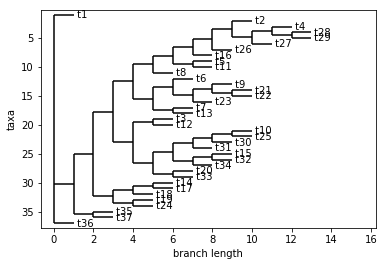

In [47]:
Phylo.draw(mytree)

### If no branch lengths

In [69]:
mytree = Tree("/Users/pmckenz1/Desktop/projects/quartet_proj/download_simseqs/relabeled_combined.tre")

In [70]:
alltipcombns = np.array(list(itertools.combinations((np.array(range(37))+1), 4)))

In [71]:
alltruequarts = np.empty(shape = (0,4))

for combo in range(len(alltipcombns)):

    # make an array of the pairwise distances in current quartet

    distmat= np.array(( #mytree.distance(("t"+str(alltipcombns[0][0])),("t"+str(alltipcombns[0][0]))),
                        mytree.get_distance((str(alltipcombns[combo][0])),(str(alltipcombns[combo][1]))),
                        mytree.get_distance((str(alltipcombns[combo][0])),(str(alltipcombns[combo][2]))),
                        mytree.get_distance((str(alltipcombns[combo][0])),(str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][1]))),
                        mytree.get_distance((str(alltipcombns[combo][1])),(str(alltipcombns[combo][2]))),
                        mytree.get_distance((str(alltipcombns[combo][1])),(str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][2]))),
                        mytree.get_distance((str(alltipcombns[combo][2])),(str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][2]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][3])))) )
    ))

    # now select the closest two and group them against the other two.

    closest2 = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]][np.argmin(distmat)] # corresponds to each distance comparison
    truequartetidxs = closest2+list(set([0,1,2,3]) - set(closest2)) # make the true quartet
    truequartet = [alltipcombns[combo][i] for i in truequartetidxs]
    alltruequarts = np.vstack([alltruequarts,np.array(truequartet)])
alltruequarts = alltruequarts.astype(int)

### If branch lengths

In [25]:
alltruequarts = np.empty(shape = (0,4))

for combo in range(len(alltipcombns)):

    # make an array of the pairwise distances in current quartet

    distmat= np.array(( #mytree.distance(("t"+str(alltipcombns[0][0])),("t"+str(alltipcombns[0][0]))),
                        mytree.distance(("t"+str(alltipcombns[combo][0])),("t"+str(alltipcombns[combo][1]))),
                        mytree.distance(("t"+str(alltipcombns[combo][0])),("t"+str(alltipcombns[combo][2]))),
                        mytree.distance(("t"+str(alltipcombns[combo][0])),("t"+str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][1]))),
                        mytree.distance(("t"+str(alltipcombns[combo][1])),("t"+str(alltipcombns[combo][2]))),
                        mytree.distance(("t"+str(alltipcombns[combo][1])),("t"+str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][2]))),
                        mytree.distance(("t"+str(alltipcombns[combo][2])),("t"+str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][2]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][3])))) )
    ))

    # now select the closest two and group them against the other two.

    closest2 = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]][np.argmin(distmat)] # corresponds to each distance comparison
    truequartetidxs = closest2+list(set([0,1,2,3]) - set(closest2)) # make the true quartet
    truequartet = [alltipcombns[combo][i] for i in truequartetidxs]
    alltruequarts = np.vstack([alltruequarts,np.array(truequartet)])
alltruequarts = alltruequarts.astype(int)

In [72]:
alltruequarts[0:10]

array([[ 2,  4,  1,  3],
       [ 2,  5,  1,  3],
       [ 1,  3,  2,  6],
       [ 1,  3,  2,  7],
       [ 2,  8,  1,  3],
       [ 1,  3,  2,  9],
       [ 1,  3,  2, 10],
       [ 2, 11,  1,  3],
       [ 3, 12,  1,  2],
       [ 1,  3,  2, 13]])

In [73]:
dump_qmc(quartets = alltruequarts,tempfiledir= "download_simseqs/")

### if "t[number]" tip names

In [33]:
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="simtreeTRUE.phy",
         tipnames=["t" + str(i+1) for i in range(37)])

### if [number] tip names

In [74]:
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="simtreeTRUE.phy",
         tipnames=[str(i+1) for i in range(37)])

### Deren code to test QMC

In [101]:
import subprocess as sps
class QMC_test(object):
    def __init__(self, ntips):
        
        ## load in tree
        self.toytree = toytree.rtree(ntips)
        self.tree = self.toytree.tree
        self.namedict = {}

        ## convert tip names to indexes
        leaf = 0
        for node in self.tree.traverse():
            if node.is_leaf():
                ## store old name
                self.namedict[leaf] = node.name
                ## set new name
                node.name = leaf
                ## advance counter
                leaf += 1    

        
    ## methods 
    def get_all_combs(self, set1, set2, as_list=False):
        qiter = (sorted(i) + sorted(j) for (i, j) in itertools.product(
                    itertools.combinations(set1, 2), 
                    itertools.combinations(set2, 2),
                ))
        
        ## option to return as list 
        if as_list:
            return list(qiter)
        ## but returning as generator is more efficient
        else:
            return qiter

        
    def decompose_to_quartets(self):
                
        ## store quartet sets
        qrts = set()
        
        ## get all tips in tree as a set
        n_all = set(self.tree.get_leaf_names())
    
        ## traverse tree
        for node in self.tree.traverse():
            ## skip root or tip nodes
            if not (node.is_root() or node.is_leaf()):
                
                ## get all tips below this node
                below = set(node.get_leaf_names())
                above = n_all - below

                ## get all combinations of 2 above and 2 below this node
                for qrt in self.get_all_combs(above, below):
                   
                    ## add to quartet set
                    qrts.add(tuple(sorted(qrt)))
        
        ## store qrts  
        return qrts
    
    
    def write_qrts_to_qmc_format(self, qrts):
        dump = ["{},{}|{},{}".format(*i) for i in qrts]
        with open("quartets.txt", "w") as outfile:
            outfile.write("\n".join(dump))
            
            
    def run_qmc_on_quartets_file(self):
        
        ## run qmc on quartets file
        cmd = [ip.bins.qmc, "qrtt=./quartets.txt", "otre=./tre.tmp"]
        proc = sps.Popen(cmd)
        proc.communicate()
        
        ## read in tree file and return as toytree object
        tre = toytree.tree("./tre.tmp")
                
        ## put names back onto qmc tree tips
        for node in tre.tree.traverse():
            if node.is_leaf():
                node.name = self.namedict[int(node.name)]
        
        return tre
        
            
    def run(self):
        ## get quartets
        qrts = self.decompose_to_quartets()
        
        ## dump to qmc to write quartets file
        self.write_qrts_to_qmc_format(qrts)
        
        ## infer supertree
        tre = self.run_qmc_on_quartets_file()

        return tre
    
    
    def run_reps_on_same_quartets_file(self, nreps):

        ## test over replicate runs
        reps = []

        ## draw the true tree
        qmc.toytree.draw(width=300, height=350);

        ## reuse the same set of quartets in each rep
        qrts = qmc.decompose_to_quartets()

        ## write quartets to file
        qmc.write_qrts_to_qmc_format(qrts)

        ## store number of inferred trees with a difference
        diff = 0

        ## iterate over reps
        for rep in range(nreps):
            tre = qmc.run_qmc_on_quartets_file()
            reps.append(tre)

            ## measure difference using robinson-foulds
            rb = qmc.tree.robinson_foulds(tre.tree, unrooted_trees=True)

            ## if any difference store it
            if rb[0]:
                diff += 1

        print "{} trees different / {} total runs".format(diff, nreps)

In [94]:
qmc = QMC_test(20)

In [112]:
qmc.toytree.draw(width=300,height=500)

(<toyplot.canvas.Canvas at 0x12b614790>,
 <toyplot.coordinates.Cartesian at 0x12b9aeb90>)

0 1 2 8 18 26 27 3 4 9 19 20 10 21 28 32 33 5 11 12 6 13 14 7 15 22 29 30 16 23 24 17 25 31 34 35 36

In [110]:
tre = qmc.run()
tre.draw(height=500, width=300);

t-10 t-11 t-13 t-25 t-29 t-30 t-32 t-5 t-6 t-14 t-26 t-27 t-33 t-15 t-16 t-34 t-36 t-35 t-4 t-31 t-28 t-24 t-22 t-21 t-19 t-18 t-12 t-9 t-3 t-23 t-20 t-17 t-8 t-7 t-2 t-1 t-0

In [113]:
## does this tree match the input tree?
matches = tre.tree.robinson_foulds(qmc.tree, unrooted_trees=True)[0] == 0
print "inferred tree matches input tree = {}".format(matches)

inferred tree matches input tree = True
